In [1]:
import numpy as np
from osgeo import gdal, osr
import rasterio as rio
import torch
import scipy
from scipy import misc
import matplotlib.pyplot as plt

In [2]:
MM_TO_PIXEL = 3.25
MM2_TO_M2 = 1000000


In [3]:
# dataset_orthophoto = gdal.Open('B2K_5_ortho.tiff')
dataset_dem = gdal.Open('Bhagina to Kajra 5 DEM.tif')
# dataset_orthophoto = dataset_orthophoto.GetRasterBand(1)

print(dataset_dem.RasterCount)
# print(dataset_orthophoto.RasterXSize, dataset_orthophoto.RasterYSize)

# raster_orthophoto = misc.imread('B2K_5_ortho.tiff')
# np.save('orthopho_raster.npy', raster_orthophoto)

1


In [4]:
SLICE_SIZE = 512
dem_array = np.array(dataset_dem.ReadAsArray())
# ortho_array = np.array(dataset_orthophoto.ReadAsArray())


In [5]:
import matplotlib
import numpy as np
from matplotlib import patches
from tqdm import tqdm
import cv2


def show_image(image, bboxes):
    print('starting')
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    for box in tqdm(bboxes):
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((y_min, x_max), y_max - y_min,
                                 x_max - x_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    print("hello")
    plt.savefig("test.png")

def show_image_gray_with_rect(image, box):

    fig, ax = plt.subplots(1, figsize = (10, 10))
    ax.imshow(image)

    x_min, y_min, x_max, y_max = box
    
    rect = patches.Rectangle((y_min, x_max), y_max - y_min,
        x_max - x_min, linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

def show_image_gray_with_rect2(image, box):

    ig, ax = plt.subplots(1, figsize = (10, 10))
    ax.imshow(image)

    col, row = image.shape

    x_min, y_min, x_max, y_max = box
    anchor = (x_min, y_min)
    print('anchor ', anchor)

    rect = patches.Rectangle(anchor, x_max - x_min, y_max - y_min,
        linewidth=1, edgecolor='r', facecolor='none')
    
    ax.add_patch(rect)


def show_image_2(image):

    r, g, b = image[0], image[1], image[2]
    rgb_image = np.stack([r, g, b], axis=-1)
    plt.imshow(rgb_image)
    plt.savefig("test1.png")

def show_image_3(image):

    plt.imshow(image)
    plt.savefig("test2.png")

In [6]:
def coord_converter(xmin_photo, ymin_photo, xmax_photo, ymax_photo, dataset_photo, dataset_dem):

    # Get geotransform of the orthophoto
    geotransform_photo = dataset_photo.GetGeoTransform()

    # Get the real world coordinates
    x_min_real = geotransform_photo[0] + xmin_photo * \
        geotransform_photo[1] + ymin_photo * geotransform_photo[2]
    y_min_real = geotransform_photo[3] + xmin_photo * \
        geotransform_photo[4] + ymin_photo * geotransform_photo[5]

    x_max_real = geotransform_photo[0] + xmax_photo * \
        geotransform_photo[1] + ymax_photo * geotransform_photo[2]
    y_max_real = geotransform_photo[3] + xmax_photo * \
        geotransform_photo[4] + ymax_photo * geotransform_photo[5]

    # use real word coords on the geotagged orthophoto
    geotransform_photo_dem = dataset_dem.GetGeoTransform()

    srs = osr.SpatialReference()
    srs.ImportFromWkt(dataset_dem.GetProjection())

    coord_transform = osr.CoordinateTransformation(srs, srs.CloneGeogCS())

    # Convert the real-world coordinates to projected coordinates
    x_proj_min, y_proj_min, _ = coord_transform.TransformPoint(
        x_min_real, y_min_real)
    x_proj_max, y_proj_max, _ = coord_transform.TransformPoint(
        x_max_real, y_max_real)

    print(x_proj_min, y_proj_min)
    print(x_proj_max, y_proj_max)

    # Apply the geotransform_photoation to obtain pixel coordinates
    # x_min_dem = int(
    #     (x_proj_min - geotransform_photo_dem[0]) / geotransform_photo_dem[1])
    # y_min_dem = int(
    #     (y_proj_min - geotransform_photo_dem[3]) / geotransform_photo_dem[5])

    # x_max_dem = int(
    #     (x_proj_max - geotransform_photo_dem[0]) / geotransform_photo_dem[1])
    # y_max_dem = int(
    #     (y_proj_max - geotransform_photo_dem[3]) / geotransform_photo_dem[5])

    td0 = geotransform_photo_dem[0]
    td1 = geotransform_photo_dem[1]
    td2 = geotransform_photo_dem[2]
    td3 = geotransform_photo_dem[3]
    td4 = geotransform_photo_dem[4]
    td5 = geotransform_photo_dem[5]


    x_min_dem = int(
        ((x_proj_min - td0)*td5 - (y_proj_min - td3)*td2)/(td1*td5 - td2*td4)
    )

    y_min_dem = int(
        ((x_proj_min - td0)*td4 - (y_proj_min - td3)*td1)/(td2*td4 - td1*td5)
    )

    x_max_dem = int(
        ((x_proj_max - td0)*td5 - (y_proj_max - td3)*td2)/(td1*td5 - td2*td4)
    )

    y_max_dem = int(
        ((x_proj_max - td0)*td4 - (y_proj_max - td3)*td1)/(td2*td4 - td1*td5)
    )
    # Note the last two items are the real world coordinates of the centroid of the bbox to identify and locate each pothole
    return x_min_dem, y_min_dem, x_max_dem, y_max_dem, (x_min_real + x_max_real)/2, (y_min_real + y_max_real)/2


In [7]:
def real_world_coords(xmin, ymin, xmax, ymax, dataset):

    geotransform = dataset.GetGeoTransform()
    x_min_real = geotransform[0] + xmin * geotransform[1] + ymin * geotransform[2]
    y_min_real = geotransform[3] + xmin * geotransform[4] + ymin * geotransform[5]

    x_max_real = geotransform[0] + xmax * geotransform[1] + ymax * geotransform[2]
    y_max_real = geotransform[3] + xmax * geotransform[4] + ymax * geotransform[5]

    return x_min_real, y_min_real, x_max_real, y_max_real


In [8]:
def coord_converter_modified(x_min_real, y_min_real, x_max_real, y_max_real, dataset_dem):
    
    geotransform_photo_dem = dataset_dem.GetGeoTransform()

    srs = osr.SpatialReference()
    srs.ImportFromWkt(dataset_dem.GetProjection())

    coord_transform = osr.CoordinateTransformation(srs, srs.CloneGeogCS())

    x_proj_min, y_proj_min, _ = coord_transform.TransformPoint(
        x_min_real, y_min_real)
    x_proj_max, y_proj_max, _ = coord_transform.TransformPoint(
        x_max_real, y_max_real)

    print(x_proj_min, y_proj_min)
    print(x_proj_max, y_proj_max)

    td0 = geotransform_photo_dem[0]
    td1 = geotransform_photo_dem[1]
    td2 = geotransform_photo_dem[2]
    td3 = geotransform_photo_dem[3]
    td4 = geotransform_photo_dem[4]
    td5 = geotransform_photo_dem[5]


    x_min_dem = int(
        ((x_proj_min - td0)*td5 - (y_proj_min - td3)*td2)/(td1*td5 - td2*td4)
    )

    y_min_dem = int(
        ((x_proj_min - td0)*td4 - (y_proj_min - td3)*td1)/(td2*td4 - td1*td5)
    )

    x_max_dem = int(
        ((x_proj_max - td0)*td5 - (y_proj_max - td3)*td2)/(td1*td5 - td2*td4)
    )

    y_max_dem = int(
        ((x_proj_max - td0)*td4 - (y_proj_max - td3)*td1)/(td2*td4 - td1*td5)
    )

    # Note the last two items are the real world coordinates of the centroid of the bbox to identify and locate each pothole
    return x_min_dem, y_min_dem, x_max_dem, y_max_dem, (x_min_real + x_max_real)/2, (y_min_real + y_max_real)/2

def calc_severity(volume, dims, max_depth_floor):

    xlen, ylen = dims
    xlen *= MM_TO_PIXEL
    ylen *= MM_TO_PIXEL

    width = max(xlen, ylen)
    max_depth_floor *= 1000 #convert to mm

    if width >= 500:
        if max_depth_floor >= 25 and max_depth_floor <= 50:
            return 'medium'
        elif max_depth_floor > 50:
            return 'large'
        else:
            return 'medium'
    
    else:
        if max_depth_floor <= 25:
            return 'small'
        else:
            return 'medium'

    



In [9]:
p1_coord = [(75.686111775,28.354054080), (75.686120273,28.354046645)] #[min, max]


In [10]:
# Transform coordinates to DEM

vals = coord_converter_modified(p1_coord[0][0], p1_coord[0][1], p1_coord[1][0], p1_coord[1][1], dataset_dem)
print(vals)

75.686111775 28.35405408
75.686120273 28.354046645
(34630, 31851, 34758, 31978, 75.686116024, 28.3540503625)


In [11]:
# show_image_3(dem_array[4000:6000, 4000:7000])
xmin, ymin, xmax, ymax = vals[0], vals[1], vals[2], vals[3]

34630 31851 34758 31978
(127, 128)
269.5097
269.5392


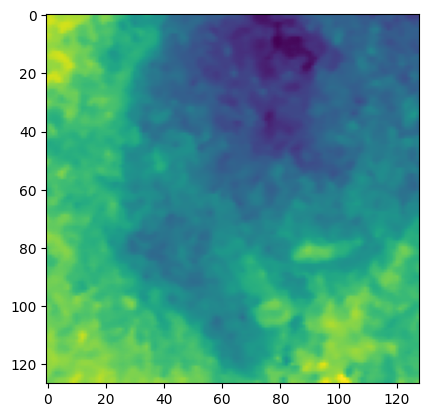

In [12]:
# print("xmin, xmax, ymin, ymax", vals[0], vals[2], vals[1], vals[3])
print(xmin, ymin, xmax, ymax)

pothole_image = dem_array[ymin:ymax, xmin:xmax]
print(pothole_image.shape)
print(dem_array[ymin][xmax])
print(pothole_image[1][1])
show_image_3(pothole_image)

# show_image_gray_with_rect(pothole_image, (vals[1], vals[0], vals[3], vals[2]))


In [13]:

def calculate_volume_and_maxdepth(bbox):

    x_min_dem, y_min_dem, x_max_dem, y_max_dem, x_real, y_real = bbox
    sliced_dem = dem_array[y_min_dem:y_max_dem, x_min_dem:x_max_dem]
    # print(sliced_dem)
    max_depth = np.max(sliced_dem)
    min_depth = np.min(sliced_dem)
    # print("max, min depth ", max_depth, min_depth)
    bbox_y_dim = int(x_max_dem - x_min_dem)
    bbox_x_dim = int(y_max_dem - y_min_dem)

    # We shall use our min depth as the floor depth

    sliced_dem = sliced_dem - min_depth

    volume = 0
    pixel_area = MM_TO_PIXEL*MM_TO_PIXEL/MM2_TO_M2

    for i in range(bbox_x_dim):
        for j in range(bbox_y_dim):    
            depth_wrt_floor = sliced_dem[i][j]
            volume += pixel_area*depth_wrt_floor
        
        # volume_max_depth.append(volume, max_depth - min_depth, (x_real, y_real))  # contains the volume, the max depth, and the real world coords of the potholes
    
    return volume, (bbox_x_dim, bbox_y_dim), np.max(sliced_dem)

In [14]:
data = calculate_volume_and_maxdepth(vals)
volume, dims, max_depth_floor = data
print(data)

(0.003526491508483884, (127, 128), 0.040039062)


In [15]:
result = calc_severity(volume, dims, max_depth_floor)
result

'medium'